# Bowerbird Agents Model

## Rachel and Julia 
Key
Notes- Parameters contain underscores, while functions don't

SB: Stay at bower

FG: Foraging

MT: Maraud travel (travel to rival's bower)

MA: Maraud action (destroy bower if absent, have antagonistic interaction in present)

MR: Maraud return (return to own bower)

RB: Repair own bower

a=-1: denotes a staying at bower action on ticket

a=-2: denotes a foraging action on ticket

a=-3: denotes a female visiting action on a ticket

a=-4: denotes travel to another male's bower

a=-5: denotes marauding of another male's bower

a=-6: denotes returning from another male's bower

a=-7: denotes a bower repair action on a ticket

target: the male an action is preformed on. For maurading, the target is the bird under potential attack. For mating, target is male being mated with. For other activities other then maurading and mating, owner and target are the same.

owner: The male or female actively performing an action. For mating, the female is the owner. For all other activities, the owner is male.

networkwriter: generates network where everybird is connected

addtotimeline: adds tickets to timeline

travel_times_linear_p: generates a matrix that contains the probabilities of travelling to a given a bower 
if the relationship between distance and travel preference is linear

improb: The probability of traveling improb_distance or less

improb_distance: The distance at which there is only a (1-improb)% chance of choosing to travel

lamb: lambda calculated by solving improb=1-numpy.exp(-lamb*improb_distance)

bower_states: options are 1 (bower intact) and 0 (bower destroyed-will never be the case when all guarders) and another value for time that mating will end (assuming mating is happening)

male_states: options are [leave_time] (male present at bower) and 0 (male absent from bower) NOTE: Want to update male_states to include targ for the purposes of modifying tickets due to female visits (when we introduce them).

fitness_states: keeps track of number of matings a given male has had

strategy_states: Given the option of SB and MT, will choose MT strategy_states proportion of the time

males: total number of male bowerbirds in the network

male_dist: the males by males matrix with distances between each male

tau: Length of time an activity takes. If a foraging ticket has a tau of 0.5 and occurs at t=1, then the bird is foraging for 30 minutes, at which point a SB activity will start (at t=1.5).

t_court: the amount of time it takes a female to court+mate with a male, generated from a normal distribution
not_maraud_time: the time added to SB by guarders

t_max: the maximum time 

FperM: the number of sexualy mature females per sexually mature male

timeline: A sorted dictionary containing tickets with times, taus, actions, owners, and target. It's sorted by time, and secondarily by owner (if the times on the tickets are identical)





Note to self: think of female visit tickets as female travel tickets
The time on the ticket represents the time at which the female arrives at the male's bower (finishes traveling to it)

In [1]:
import math
from sortedcontainers import SortedDict
import random
import numpy 
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

In [2]:
# Global Parameters:
males = 20
t_max = 12 #2 months in hrs (assume no nights so 12 hr = 1 day)
timeline = SortedDict() #New and improved timeline (using a sorted dictionary)!

FV_param = [0, t_max] #5days, tmax/3 #0.2 #males/0.19 #totally random

FG_k=1.5 #the shape of the gamma distribution rv used to generate FG taus
FG_theta=5 #the scale of the gamma distribution rv used to generate FG taus
FG_divisor=60

SB_param = 1.5 #larger values lead to bowerstay ending earlier, because taus are smaller

RB_param = 6 #made up -- takes 30mins (every time -- no distribution) to repair bower

MA_param = 0.1 #made up -- takes 6mins (every time -- no distribution) to maraud bower

#taus for in-between next_forages
FG_tau_mean, FG_tau_std = .4, .167 #mean and sd of truncated normal distribution rv to find a male's time until next FG
FG_tau_range = [0, 1] #maximum and minimum FG taus
FG_tau_norm_range = [(FG_tau_range[0] - FG_tau_mean) / FG_tau_std, (FG_tau_range[1] - FG_tau_mean) / FG_tau_std] #normalized

#taus for RB and SB
RBSB_tau_mean, RBSB_tau_std = .1583, .09755 #mean and sd of truncated normal distribution rv to find a male's time until next FG
RBSB_tau_range = [0,.5] #maximum and minimum FG taus
RBSB_tau_norm_range = [(RBSB_tau_range[0] - RBSB_tau_mean) / RBSB_tau_std, (RBSB_tau_range[1] - RBSB_tau_mean) / RBSB_tau_std] #normalized

next_forage = FG_tau_std * truncnorm.rvs(FG_tau_norm_range[0], FG_tau_norm_range[1], size=males) + FG_tau_mean
bower_states = [0] * males
male_states = [0] * males 
strategy_states=[0]*males
mating_states = [0] * males
fitness_states = numpy.array([0] * males)
success_rate = 1
success_times = [] #going to change this to be a vector of times when the female leaves (at this point, sucessful mating has occured)
recents_list = []
max_visits = 6 #STEEEEVEEEE
bird_speed = 12 * 3600 #m/hr (12m/s)
x_dim, y_dim = 400, 500 #dimensions of environment
FperM = 3 #number of sexually mature females per sexually mature males in a bowerbird population
num_sims = 1
not_maraud_time = 0.15

d={} 

for i in range(males):
    d["next_forages{0}".format(i)]=[]
    d["forage_times{0}".format(i)]=[]

In [3]:
def ticketgenerator(t, tau, ow, ac, targ):
    ticket = {
        'time': t, #time at which the activity starts
        'tau': tau, #how long the activity lasts
        'owner': ow, #who is doing the activity (could be a female if action=-3)
        'action': ac, #which activity (see key)
        'target': targ, #target of the activity (owner=target unless action=-3,-4,-5, or -6)
    }
    return ticket

In [4]:
#Adds tickets to timeline- sorts by time
def addtotimeline(ticket):
    global timeline
    timeline[(ticket["time"], ticket["owner"])] = ticket

In [5]:
# creation of the environment

def envgenerator(males, x_dim, y_dim):
    Xs = numpy.random.rand(males) * x_dim
    Ys = numpy.random.rand(males) * y_dim
    return [Xs,Ys]

def dists(xy, bird_speed):
    male_dist = numpy.zeros(males * males).reshape((males, males))
    travel_times = numpy.zeros(males * males).reshape((males, males))
    for i in range(males):
        for j in range(i + 1, males):
            dist = math.sqrt((xy[0][j] - xy[0][i]) ** 2 + (xy[1][j] - xy[1][i]) ** 2)
            travel = dist / bird_speed
            male_dist[j][i] = dist
            male_dist[i][j] = dist
            travel_times[j][i] = travel
            travel_times[i][j] = travel
    return [male_dist,travel_times]

# the probability of choosing a neighbor at distance x is proportional to exp(-\lambda x)
# choose lambda such that 99% of the mass is before 800 meters
improb = 0.99
improb_distance = 800
lamb = -math.log(1 - improb) / improb_distance

#will write female preference based on cumulative exponential decay (lambda=.00576)
def preferences(male_dist, males, lamb):
    # compute exponential of each coefficient
    visit_preferences = numpy.exp(-lamb * male_dist)
    # remove the identity matrix (exp(0) = 1)
    visit_preferences = visit_preferences - numpy.eye(males)
    # make rows sum to one
    visit_preferences = (visit_preferences.transpose() / numpy.sum(visit_preferences, 1)).transpose()
    return visit_preferences

In [6]:
# function for determining the next time based on our rate parameters
def nexttau(action, ow, targ): 
    switcher = { 
        -1: RBSB_tau_std*truncnorm.rvs(RBSB_tau_norm_range[0], RBSB_tau_norm_range[1])+RBSB_tau_mean, #choose when to leave bower (generate a tau for bower stay)
        -2: numpy.random.gamma(FG_k, FG_theta)/FG_divisor, #choose when to stop foraging (generate a tau for foraging)
        -3: numpy.random.uniform(FV_param[0], FV_param[1]), #FV_param... totally arbitrary so we should think about it
        -4: travel_times[ow][targ],
        -5: MA_param, #in the future we'll do something with it
        -6: travel_times[targ][ow],
        -7: RBSB_tau_std*truncnorm.rvs(RBSB_tau_norm_range[0], RBSB_tau_norm_range[1])+RBSB_tau_mean,
    }
    new_tau=switcher.get(action)
    return new_tau

def futurebuilder(old_tic, new_ac, new_targ): #returns new ticket after ensuring it doesn't exceed t_max
    old_t=old_tic['time']
    new_tic={}
    if math.isclose(old_t, t_max, rel_tol=0, abs_tol=.0000001)==0: #if old_t is not essentially t_max
        ow=old_tic['owner']
        new_tau=nexttau(new_ac, ow, new_targ)
        end_t=old_t+new_tau #this time is the time when the action has ended
        if end_t>t_max: 
            new_tau=new_tau-(end_t-t_max) #modify the new_tau so end_t will be t_max
            end_t=old_t+new_tau #recalculate end_t
        new_tic=ticketgenerator(end_t, new_tau, ow, new_ac, new_targ) #now the time represents the end time for the action
    return new_tic


In [7]:

def statechanger(new_tic): #calls functions to change states of males i.e. for bower destruction, absence from bower
    ac=new_tic['action']
    if ac==-2 or ac==-4: #forage or maraud travel 
        male_states[new_tic['owner']]=0 #male_states of the ticket's owner is updated to show absence from bower
    elif ac==-1: #stay at bower
        male_states[new_tic['owner']]=new_tic['time'] #male_states of the ticket's owner becomes the time at which the male will leave the bower
    elif ac==-5: #maraud action
        targ=new_tic['target']
        if bower_states[targ]==0 and male_states[targ]==0:
            bower_states[targ]=-1*RB_param
    elif ac==-7: #repair bower
        ow=new_tic['owner']
        tau=new_tic['tau']
        if bower_states[ow]+tau>0:
            new_tic['time']-=bower_states[ow]+tau #think about it more in the AM :)
            tau=-1*bower_states[ow]
            new_tic['tau']=tau
        bower_states[ow]+=tau
        male_states[ow]=new_tic['time'] #although it doesn't matter from an FV POV
    elif ac==-3:
        FVstatechanger(new_tic)
    else:
        pass

    
def FVstatechanger(new_tic): #here the t is the start time... idea for future: female start and end tics?
    targ=new_tic['target']
    t=new_tic['time']
    SB_time=male_states[targ]
    if bower_states[targ]==0 and SB_time!=0 and mating_states[targ]<t:
        fitness_states[targ]+=1
        mating_end=.25+t #can use dist instead of .25
        if t>SB_time:
            #print("t is less than mating end")
            old_tau=timeline[(SB_time, targ)]['tau'] #access the tau of the SB_tic -- we will use it to make a new one
            timeline[(SB_time, targ)]['action']=1 #nullify currently scheduled SB_tic
            #now make a new SB_tic with modified tau and time (so that male leaves right after finishing mating)
            truncator=0
            if mating_end>t_max:
                truncator=mating_end-t_max  
            SB_tau=old_tau+(mating_end-SB_time)-truncator
            SB_time=mating_end-truncator
            SB_tic=ticketgenerator(SB_time, SB_tau, targ, -1, targ)
            addtotimeline(SB_tic)
        mating_states[targ]=mating_end
        male_states[targ]=SB_time


#choose what action / sequence of actions to do next
def decider(tic):
    ow = tic['owner']
    ac = tic['action'] 
    t = tic['time']
    targ=ow #will be reset in the case of -4
    if t>next_forage[ow]:
        d["forage_times{0}".format(ow)].append(t)
        #print("t is greater than next_FG[{:f}]: t={:f}, next_FG={:f}".format(ow, t, next_forage[ow]))
        new_ac=-2 #forage
        d["next_forages{0}".format(ow)].append(next_forage[ow])
        next_forage[ow] = t+FG_tau_std*truncnorm.rvs(FG_tau_norm_range[0], FG_tau_norm_range[1])+FG_tau_mean #forage 30 times / day on average (but underestimates)
    elif bower_states[ow]<0:
        new_ac=-7 #repair bower
    else:
        if random.random()<strategy_states[ow]: #if male chooses to maraud 
            targ=numpy.random.choice(list(range(males)), p=visit_preferences[ow])
            new_ac=-4 #maurad travel
        else: #if male chooses to stay at bower
            new_ac=-1 #stay at bower
    new_tic=futurebuilder(tic, new_ac, targ) #ONE IDEA -- separate ticket generation and adding to timeline
    return new_tic
   

In [8]:
num_males=list(range(5, 80, 5))

In [9]:


xy = envgenerator(males, x_dim, y_dim)

travel_mats=dists(xy, bird_speed)
male_dist=travel_mats[0]
travel_times=travel_mats[1]

visit_preferences=preferences(male_dist, males, lamb)

for i in range(males):
    addtotimeline(ticketgenerator(0.0, 0.0, i, -2, i))


#print(timeline)

In [10]:
for key in timeline:
    tic=timeline[key]
    ac=tic['action']
    ow=tic['owner']
    targ=tic['target']
    if ac==-4 or ac==-5:
        #generate a -5 or -6 tic as new_tic and pass it in
        new_tic=futurebuilder(tic, ac-1, targ)
    #elif ac==-3:
    #    #d["rl{0}".format(ow)]=FVtickethandler(next_tic, d["rl{0}".format(ow)])
    #    new_tic=FVtickethandler()
    else:
        new_tic=decider(tic)
    if new_tic=={}:
        print("done (for some owner)!")
    else:
        statechanger(new_tic)
        addtotimeline(new_tic)


done (for some owner)!
done (for some owner)!
done (for some owner)!
done (for some owner)!
done (for some owner)!
done (for some owner)!
done (for some owner)!
done (for some owner)!
done (for some owner)!
done (for some owner)!
done (for some owner)!
done (for some owner)!
done (for some owner)!
done (for some owner)!
done (for some owner)!
done (for some owner)!
done (for some owner)!
done (for some owner)!
done (for some owner)!
done (for some owner)!


In [11]:
#print(timeline)
print(len(timeline)/(t_max*(males**2)))

0.325625


In [12]:
timeline2=SortedDict()

def addtotimeline2(ticket):
    global timeline2
    timeline2[(ticket["owner"], ticket["time"])] = ticket
    
max_t=1000
acc=0
for key in timeline:
    tic=timeline[key]
    if acc<max_t:
        print(tic)
        #addtotimeline2(tic)
    acc+=1
    
#print(timeline2)
    

{'time': 0.0, 'tau': 0.0, 'owner': 0, 'action': -2, 'target': 0}
{'time': 0.0, 'tau': 0.0, 'owner': 1, 'action': -2, 'target': 1}
{'time': 0.0, 'tau': 0.0, 'owner': 2, 'action': -2, 'target': 2}
{'time': 0.0, 'tau': 0.0, 'owner': 3, 'action': -2, 'target': 3}
{'time': 0.0, 'tau': 0.0, 'owner': 4, 'action': -2, 'target': 4}
{'time': 0.0, 'tau': 0.0, 'owner': 5, 'action': -2, 'target': 5}
{'time': 0.0, 'tau': 0.0, 'owner': 6, 'action': -2, 'target': 6}
{'time': 0.0, 'tau': 0.0, 'owner': 7, 'action': -2, 'target': 7}
{'time': 0.0, 'tau': 0.0, 'owner': 8, 'action': -2, 'target': 8}
{'time': 0.0, 'tau': 0.0, 'owner': 9, 'action': -2, 'target': 9}
{'time': 0.0, 'tau': 0.0, 'owner': 10, 'action': -2, 'target': 10}
{'time': 0.0, 'tau': 0.0, 'owner': 11, 'action': -2, 'target': 11}
{'time': 0.0, 'tau': 0.0, 'owner': 12, 'action': -2, 'target': 12}
{'time': 0.0, 'tau': 0.0, 'owner': 13, 'action': -2, 'target': 13}
{'time': 0.0, 'tau': 0.0, 'owner': 14, 'action': -2, 'target': 14}
{'time': 0.0, '

In [13]:
print(timeline2)

SortedDict({})


[0.45623146580229645, 0.9656529832734141, 1.218882853583936, 1.6965633774124886, 1.9014203977350252, 2.5326994565918097, 2.9016231632632024, 3.378895981310097, 3.8455623983360243, 4.529957945347859, 5.1416812664729425, 5.400708051643746, 6.031467278141133, 6.491201348736711, 7.0281123056154104, 7.911050872925431, 8.45592960889025, 8.877701469408374, 9.787282746847838, 10.572893226272045, 11.026005631080709, 11.982110703996854]
[0.33233156679531495, 1.142122313654216, 1.5352698398333313, 2.374186047681796, 2.8013234331864525, 3.087645327924895, 3.7182166499888845, 4.54881853518103, 5.0685235544420495, 5.608117512263961, 5.964646150436229, 6.466107267249369, 6.867173228895172, 7.314415528970477, 7.9635448122917705, 8.39808809930104, 8.78666514039842, 9.491276130432926, 9.968048889106901, 10.727439473584496, 11.167207934296998, 11.5491895449153]
[0.29481263957308773, 1.180016144100506, 1.5786035071549405, 1.8664810921773909, 2.4344783056000128, 2.8788161749176417, 3.5526545789882187, 3.95

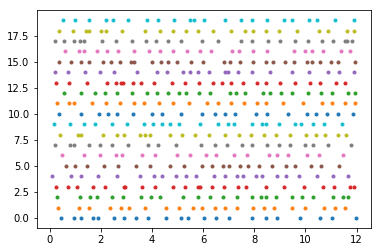

In [14]:
plt.figure()
for i in range(males):
    dic=d["next_forages{0}".format(i)]
    print(dic)
    line=[i]*len(dic)
    plt.plot(dic,line,'.')


22
[0.7211121704685075, 1.0218782053611632, 1.3014289743277496, 1.7431613340999164, 2.084819784312333, 2.7248249234911666, 2.9947044474716344, 3.3955532588987603, 3.9726886253646905, 4.703923001411741, 5.237452052690341, 5.664026066849057, 6.17429441975767, 6.568861518119386, 7.283735382799474, 8.000380742737732, 8.577985120277514, 9.179238213425172, 9.9246286372903, 10.592408308597157, 11.102460868779804, 12.0]
22
[0.34702257807984666, 1.2960169371625376, 1.790207519093388, 2.455066344791993, 2.8297441064217104, 3.189106189882871, 3.774093750094948, 4.7786361898670755, 5.222083122423695, 5.64595410568699, 5.979527956512962, 6.507293726419885, 6.949829107572363, 7.384883613837035, 7.972831197160605, 8.460291312214382, 9.032883560037199, 9.652169447645317, 10.025694439114455, 10.76523208875097, 11.254497904276967, 11.583801364319234]
24
[0.38620555399784495, 1.3997943214844604, 1.5800124972358283, 2.0872839239256162, 2.5030512098710114, 2.9629796106631385, 3.623845519719146, 4.130752324

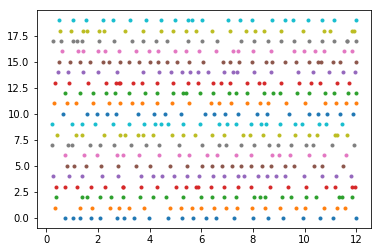

In [15]:
plt.figure()
for i in range(males):
    dic=d["forage_times{0}".format(i)]
    print(len(dic))
    print(dic)
    line=[i]*len(dic)
    plt.plot(dic,line,'.')


In [16]:
#testing FVstatechanger (without the implementation of FV_tics)

def FVstatechanger(new_tic): #here the t is the start time... idea for future: female start and end tics?
    targ=new_tic['target']
    t=new_tic['time']
    SB_time=male_states[targ]
    if bower_states[targ]==0 and SB_time!=0 and mating_states[targ]<t:
        fitness_states[targ]+=1
        mating_end=.25+t #can use dist instead of .25
        if t>SB_time:
            #print("t is less than mating end")
            old_tau=timeline2[(SB_time, targ)]['tau'] #access the tau of the SB_tic -- we will use it to make a new one
            timeline2[(SB_time, targ)]['action']=1 #nullify currently scheduled SB_tic
            #now make a new SB_tic with modified tau and time (so that male leaves right after finishing mating)
            truncator=0
            if mating_end>t_max:
                truncator=mating_end-t_max  
            SB_tau=old_tau+(mating_end-SB_time)-truncator
            SB_time=mating_end-truncator
            SB_tic=ticketgenerator(SB_time, SB_tau, targ, -1, targ)
            addtotimeline2(SB_tic)
        mating_states[targ]=mating_end
        male_states[targ]=SB_time
        

timeline2=SortedDict()

def addtotimeline2(ticket):
    global timeline2
    timeline2[(ticket["time"], ticket["owner"])] = ticket
    
bower_states = [0] * males
male_states = [1] * males 
mating_states = [0] * males

for i in range(males):
    addtotimeline2(ticketgenerator(1, 1, i, -1, i))
print(timeline2)

female_tic=ticketgenerator(0.7, 0.03, 5, -3, 0) #works at both .7 and .9 (when SB_tic must be re-written)
print(FVstatechanger(female_tic))

print(male_states)
print(mating_states)
print(timeline2)

SortedDict({(1, 0): {'time': 1, 'tau': 1, 'owner': 0, 'action': -1, 'target': 0}, (1, 1): {'time': 1, 'tau': 1, 'owner': 1, 'action': -1, 'target': 1}, (1, 2): {'time': 1, 'tau': 1, 'owner': 2, 'action': -1, 'target': 2}, (1, 3): {'time': 1, 'tau': 1, 'owner': 3, 'action': -1, 'target': 3}, (1, 4): {'time': 1, 'tau': 1, 'owner': 4, 'action': -1, 'target': 4}, (1, 5): {'time': 1, 'tau': 1, 'owner': 5, 'action': -1, 'target': 5}, (1, 6): {'time': 1, 'tau': 1, 'owner': 6, 'action': -1, 'target': 6}, (1, 7): {'time': 1, 'tau': 1, 'owner': 7, 'action': -1, 'target': 7}, (1, 8): {'time': 1, 'tau': 1, 'owner': 8, 'action': -1, 'target': 8}, (1, 9): {'time': 1, 'tau': 1, 'owner': 9, 'action': -1, 'target': 9}, (1, 10): {'time': 1, 'tau': 1, 'owner': 10, 'action': -1, 'target': 10}, (1, 11): {'time': 1, 'tau': 1, 'owner': 11, 'action': -1, 'target': 11}, (1, 12): {'time': 1, 'tau': 1, 'owner': 12, 'action': -1, 'target': 12}, (1, 13): {'time': 1, 'tau': 1, 'owner': 13, 'action': -1, 'target': 1

In [17]:
next_forage = FG_tau_std * truncnorm.rvs(FG_tau_norm_range[0], FG_tau_norm_range[1], size=males) + FG_tau_mean

In [18]:
print(numpy.mean(next_forage))

0.4456084136782862
